In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
import datetime as dt
from datetime import timedelta
# Check current directory
import os
print(os.getcwd())

/Users/sethblum/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Courses/1C51/project-repo/FinalProject_1.C01


In [3]:
# Separate function to create a DT object that is 00:15, :30, :45 or 1:00 for HE 1
# Separated out because the imported load forecasts already have a DT index, incorporated into method below

def interval_fix(intervaldt, interval):
    return intervaldt + pd.Timedelta(minutes=-15*(4-interval))

def create_time_intervals(date, hour, interval):
        dt_date = pd.to_datetime(date)
        if hour == "24:00":
            hour = "00:00"
            dt_date = dt_date + timedelta(days=1)
        hour_datetime = pd.to_datetime(hour, format='%H:%M')
        interval_time = interval_fix(dt_date,interval) + timedelta(hours=hour_datetime.hour)
        return interval_time

#def load_merge_DAMRTM_forecasts():

# Load DAM and RTM .csv
DAM = pd.read_csv('Data_Clean/DAM.csv')
RTM = pd.read_csv('Data_Clean/RTM.csv')
loadfc_df = pd.read_pickle('Data_Clean/merged_fcload.pkl')

# From RTM take Delivert Date Delivery Hour Delivery Interval and Settlement Point Price columns
RTM = RTM[['Delivery Date', 'Delivery Hour', 'Delivery Interval', 'Settlement Point Price']]

# From DAM take Delivery Date Hour Ending and Settlement Point Price columns
DAM = DAM[['Delivery Date', 'Hour Ending', 'Settlement Point Price']]

loadfc_df = loadfc_df[['interval_end_utc', 'houston_load', 'houston_diff']]
# next - add the one day timedelta below and set up the DFs to merge on datetime after expanding the DAM dataset


def expand_hourly(df):
    dam_intervals = pd.DataFrame({"Delivery Interval": range(1, 5)})
    df['key'] = 1
    dam_intervals['key'] = 1
    df = pd.merge(df, dam_intervals, on='key').drop('key', axis=1)
    return df

DAM = expand_hourly(DAM)
loadfc_df = expand_hourly(loadfc_df)

# Apply only the interval_fix to the existing DT index
loadfc_df['interval_end_utc'] = loadfc_df.apply(lambda x: interval_fix(x['interval_end_utc'], x['Delivery Interval']), axis=1)



In [4]:

# Create DT index
DAM['dt'] = DAM.apply(lambda x: create_time_intervals(x['Delivery Date'], x['Hour Ending'], x['Delivery Interval']), axis=1)

# Prepare the 'Hour Ending' column for RTM to format hours correctly and create DT index
RTM['Hour Ending'] = RTM['Delivery Hour'].astype(int).apply(lambda x: f"{x:02d}:00")
RTM['dt'] = RTM.apply(lambda x: create_time_intervals(x['Delivery Date'], x['Hour Ending'], x['Delivery Interval']), axis=1)


def prep_one_hot(df):
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day_of_week
    df['Hour'] = df.index.hour
    df['Minute'] = df.index.minute
    return df



In [5]:

# Combine DAM and RTM on Interval Time.
df = pd.merge(DAM, RTM, on=['dt'], how = 'outer', suffixes=('_DAM', '_RTM'))
loadfc_df['interval_end_utc'] = loadfc_df['interval_end_utc'].dt.tz_localize(None)
df = pd.merge(df, loadfc_df, left_on='dt', right_on='interval_end_utc', how='outer')
df.set_index('dt', inplace=True, drop = True)
prep_one_hot(df)
#  Only keep Interval Time Delivery Date and Settlement Point Price, day, month, year
df['houston_diff'] = df['houston_diff'].fillna(0)
df['houston_load'] = df['houston_load'].fillna(0)
#df = df[['Delivery Hour', 'Settlement Point Price_DAM', 'Settlement Point Price_RTM', 'Day_DAM', 'Month_DAM', 'Year_DAM', 'Day_RTM', 'Month_RTM', 'Year_RTM']]

#return df



In [21]:
df[-20000:]

,DAM,RTM,load_fc,load_diff,Day,Month,Year,Hour,Minute,RTMlag
dt,,,,,,,,,,
2023-12-29 22:15:00,22.76,29.01,11959.64,-749.323743,4.0,12.0,2023.0,22.0,15.0,22.08
2023-12-29 22:30:00,22.76,28.54,11959.64,-749.323743,4.0,12.0,2023.0,22.0,30.0,23.16
2023-12-29 22:45:00,22.76,27.61,11959.64,-749.323743,4.0,12.0,2023.0,22.0,45.0,23.42
2023-12-29 23:00:00,22.76,26.52,11959.64,-749.323743,4.0,12.0,2023.0,23.0,0.0,22.54
2023-12-29 23:15:00,20.29,25.76,0.00,0.000000,4.0,12.0,2023.0,23.0,15.0,22.56
...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:00:00,15.50,12.08,0.00,0.000000,6.0,12.0,2023.0,23.0,0.0,12.29
2023-12-31 23:15:00,15.50,12.40,0.00,0.000000,6.0,12.0,2023.0,23.0,15.0,9.00
2023-12-31 23:30:00,15.50,12.77,0.00,0.000000,6.0,12.0,2023.0,23.0,30.0,10.64


In [6]:
df = df[['Settlement Point Price_DAM', 'Settlement Point Price_RTM', 'houston_load', 'houston_diff', 'Day', 'Month', 'Year', 'Hour', 'Minute']]

In [7]:
df.rename(columns={'Settlement Point Price_DAM': 'DAM', 'Settlement Point Price_RTM': 'RTM', 'houston_load' : 'load_fc', 'houston_diff' : 'load_diff'}, inplace=True)

In [8]:
df.to_pickle('Data_Clean/merged_clean_df.pkl')

In [9]:
def load_merge_DAMRTM():

    # Load DAM and RTM .csv
    DAM = pd.read_csv('Data_Clean/DAM.csv')
    RTM = pd.read_csv('Data_Clean/RTM.csv')

    # From RTM take Delivert Date Delivery Hour Delivery Interval and Settlement Point Price columns
    RTM = RTM[['Delivery Date', 'Delivery Hour', 'Delivery Interval', 'Settlement Point Price']]

    # From DAM take Delivery Date Hour Ending and Settlement Point Price columns
    DAM = DAM[['Delivery Date', 'Hour Ending', 'Settlement Point Price']]

    from datetime import timedelta
    # Function to adjust '24:00' to '00:00' and calculate the interval time
    def create_time_intervals_corrected(hour, interval):
        if hour == "24:00":
            hour = "00:00"
        hour_datetime = pd.to_datetime(hour, format='%H:%M')
        interval_time = hour_datetime + timedelta(minutes=(interval - 5) * 15)
        return interval_time.strftime('%H:%M')

    # Expand the DAM dataset to account for 15-minute intervals
    dam_intervals = pd.DataFrame({"Delivery Interval": range(1, 5)})
    DAM['key'] = 1
    dam_intervals['key'] = 1
    DAM = pd.merge(DAM, dam_intervals, on='key').drop('key', axis=1)

    # Create the 'Interval Time' column for DAM
    DAM['Interval Time'] = DAM.apply(lambda x: create_time_intervals_corrected(x['Hour Ending'], x['Delivery Interval']), axis=1)

    # Prepare the 'Hour Ending' column for RTM to format hours correctly and create 'Interval Time'
    RTM['Hour Ending'] = RTM['Delivery Hour'].astype(int).apply(lambda x: f"{x:02d}:00")
    RTM['Interval Time'] = RTM.apply(lambda x: create_time_intervals_corrected(x['Hour Ending'], x['Delivery Interval']), axis=1)

    # For both, split up the Delivert Date into 3 columns representing day, month, and year
    DAM['Delivery Date'] = pd.to_datetime(DAM['Delivery Date'])
    DAM['Year'] = DAM['Delivery Date'].dt.year
    DAM['Month'] = DAM['Delivery Date'].dt.month
    DAM['Day'] = DAM['Delivery Date'].dt.day_of_week

    RTM['Delivery Date'] = pd.to_datetime(RTM['Delivery Date'])
    RTM['Year'] = RTM['Delivery Date'].dt.year
    RTM['Month'] = RTM['Delivery Date'].dt.month
    RTM['Day'] = RTM['Delivery Date'].dt.day_of_week

    # Combine DAM and RTM on Interval Time.
    df = pd.merge(DAM, RTM, on=['Delivery Date', 'Interval Time'], suffixes=('_DAM', '_RTM'), how = 'outer')
    #  Only keep Interval Time Delivery Date and Settlement Point Price, day, month, year
    print(df[df.isnull().any(axis=1)])
    df = df[['Delivery Hour', 'Settlement Point Price_DAM', 'Settlement Point Price_RTM', 'Day_DAM', 'Month_DAM', 'Year_DAM', 'Day_RTM', 'Month_RTM', 'Year_RTM']]
    return df

#df = load_merge_DAMRTM()
#df.to_pickle('Data_Clean/loadmergeDAMRTM.pkl')


In [12]:
import dill
# load the DF from pickle to speed pre-processing
df = pd.read_pickle('Data_Clean/merged_clean_df.pkl')

###########
# Set params
###########

# set to >1 to chop off 1/n of the data
chop = 1
lookback = 96
forecast = 96
epochs = 2

# set to 'minmax' or 'standard'. A dict after the functions are defined routes the function call
scaler = 'standard'

# the vars are dumped after the dataset construction below

###########
###########

df = df.iloc[:int(len(df)/chop)]
sequence_length = lookback + forecast

In [13]:
df['RTMlag'] = df['RTM'].shift(forecast)
X_vars = list(df.columns)
X_vars.remove('RTM')
X_vars


['DAM',
 'load_fc',
 'load_diff',
 'Day',
 'Month',
 'Year',
 'Hour',
 'Minute',
 'RTMlag']

In [16]:
df.dropna(inplace=True)
df

,DAM,RTM,load_fc,load_diff,Day,Month,Year,Hour,Minute,RTMlag
dt,,,,,,,,,,
2012-01-02 00:15:00,21.14,21.22,0.0,0.0,0.0,1.0,2012.0,0.0,15.0,14.06
2012-01-02 00:30:00,21.14,21.17,0.0,0.0,0.0,1.0,2012.0,0.0,30.0,9.78
2012-01-02 00:45:00,21.14,21.10,0.0,0.0,0.0,1.0,2012.0,0.0,45.0,15.19
2012-01-02 01:00:00,21.14,21.10,0.0,0.0,0.0,1.0,2012.0,1.0,0.0,14.23
2012-01-02 01:15:00,20.62,21.34,0.0,0.0,0.0,1.0,2012.0,1.0,15.0,14.52
...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:00:00,15.50,12.08,0.0,0.0,6.0,12.0,2023.0,23.0,0.0,12.29
2023-12-31 23:15:00,15.50,12.40,0.0,0.0,6.0,12.0,2023.0,23.0,15.0,9.00
2023-12-31 23:30:00,15.50,12.77,0.0,0.0,6.0,12.0,2023.0,23.0,30.0,10.64


In [17]:

X_continuous = df[['DAM', 'RTMlag', 'load_fc', 'load_diff']].values
# Categorical features
enc = OneHotEncoder(handle_unknown='ignore')
X_categorical = df[['Day', 'Month', 'Year', 'Hour', 'Minute']]
X_categorical = enc.fit_transform(X_categorical).toarray()

In [18]:
print(df.shape)
print(X_continuous.shape)
print(X_categorical.shape)
print(df['RTM'].shape)

(420852, 10)
(420852, 4)
(420852, 60)
(420852,)


In [6]:
import gc
gc.collect()

16

In [7]:
def non_seq_split(X_continuous, X_categorical,Y, test_size=0.2):
    X_cont_train = X_continuous[:int(len(X_continuous) * (1 - test_size))]
    X_cont_test = X_continuous[int(len(X_continuous) * (1 - test_size)):]
    X_cat_train = X_categorical[:int(len(X_categorical) * (1 - test_size))]
    X_cat_test = X_categorical[int(len(X_categorical) * (1 - test_size)):]
    Y_train = Y[:int(len(Y) * (1 - test_size))]
    Y_test = Y[int(len(Y) * (1 - test_size)):]
    return X_cont_train, X_cat_train, X_cont_test, X_cat_test, Y_train, Y_test

def trim(arr, size):
    if isinstance(arr, tuple):
        return tuple(a[size:] for a in arr)
    else:
        return arr[size:]

X_cont_train, X_cat_train, X_cont_test, X_cat_test, y_train, y_test = trim(non_seq_split(X_continuous, X_categorical, df['RTM'].values),lookback)

# commented without trimmed version
#X_cont_train, X_cat_train, X_cont_test, X_cat_test, y_train, y_test = non_seq_split(X_continuous, X_categorical, df['Settlement Point Price_RTM'].values)


def non_seq_scaler_minmax(X_cont_train, X_cont_test, Y_train, Y_test):
    Xscaler = MinMaxScaler()
    X_cont_train = Xscaler.fit_transform(X_cont_train)
    X_cont_test = Xscaler.transform(X_cont_test)
    Yscaler = MinMaxScaler()
    Y_train = Y_train.reshape(-1, 1)
    Y_test = Y_test.reshape(-1, 1)
    Y_train = Yscaler.fit_transform(Y_train)
    Y_test = Yscaler.transform(Y_test)
    return X_cont_train, X_cont_test, Y_train, Y_test, Xscaler, Yscaler

def non_seq_scaler_standardization(X_cont_train, X_cont_test, Y_train, Y_test):
    Xscaler = StandardScaler()
    X_cont_train = Xscaler.fit_transform(X_cont_train)
    X_cont_test = Xscaler.transform(X_cont_test)
    Yscaler = StandardScaler()
    Y_train = Y_train.reshape(-1, 1)
    Y_test = Y_test.reshape(-1, 1)
    Y_train = Yscaler.fit_transform(Y_train)
    Y_test = Yscaler.transform(Y_test)
    return X_cont_train, X_cont_test, Y_train, Y_test, Xscaler, Yscaler

X_cont_train, X_cont_test, y_train, y_test, Xscaler, Yscaler = non_seq_scaler_standardization(X_cont_train, X_cont_test, y_train, y_test)
X_train = np.concatenate((X_cont_train, X_cat_train), axis=1)
X_test = np.concatenate((X_cont_test, X_cat_test), axis=1)



In [8]:

X_train.shape

(336670, 69)

In [9]:

def rev_encode_data(X, y, lookback = lookback, forecast=forecast):
    """
    Encode the data for training an LSTM model, including creating sequences and splitting into input and target.

    Parameters:
    X (numpy.ndarray): The input data array.
    y (numpy.ndarray): The target variable array.
    lookback (int): The number of timesteps to look back (48 hours with 15 minute intervals).
    forecast (int): The number of timesteps to forecast (24 hours with 15 minute intervals).

    Returns:
    X_seq (numpy.ndarray): The encoded input data with sequences.
    y_seq (numpy.ndarray): The encoded target variable array with sequences.
    """

    if len(X) != len(y):
        raise ValueError("X and y must have the same length.")
    l = lookback
    f = forecast
    X_seq = []
    y_seq = []

    for i in range(len(X) - l - f + 1):
        Xtemp = X[i:i+l+f]
        ytemp = y[i+l:i+l+f]
        X_seq.append(Xtemp)
        y_seq.append(ytemp)
        if i % 500 == 0:
            print(i)

    return np.array(X_seq), np.array(y_seq)


# Encode the train and test data
X_train_encoded, y_train_encoded = rev_encode_data(X_train, y_train, lookback=lookback, forecast=forecast)
X_test_encoded, y_test_encoded = rev_encode_data(X_test, y_test, lookback=lookback, forecast=forecast)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
8500

In [10]:
import gc
gc.collect()

0

In [11]:
# BE AWARE: depeding on size of might want to stratify by months when splitting
#train_test_split(X, Y_reshaped, months_reshaped, test_size=test_size, stratify=months_reshaped, random_state=42)

In [12]:
def relative_mae(y_true, y_pred):
    """
    Calculates the Relative Mean Absolute Error (Relative MAE). an arguably better metric is the relative MAE (rMAE). 
    Similar to MASE, rMAE normalizes the MAE by the MAE of a naive forecast. 
    However, instead of considering the in-sample dataset, the naive forecast is built based on the out-of-sample dataset.
    
    Parameters:
        y_true (array-like): True values.
        y_pred (array-like): Predicted values.
        
    Returns:
        float: The Relative Mean Absolute Error.
    """
    mae = np.mean(np.abs(y_pred - y_true))  # Calculate the Mean Absolute Error
    mean_actual = np.mean(np.abs(y_true))  # Calculate the mean of absolute values of actual data
    
    return mae / mean_actual


In [13]:
# def direction_accuracy(y_true, y_pred):
#     """
#     For applications like virtual bidding, when it is difficult to predict the magnitude of the price difference,
#     it is still valuable to predict the sign of the price difference where
    
#     Parameters
#     n = total number of correctly detected direction (or sign) of price difference,
#     N = total number of price differences. 
#     """
    
#     # Calculate the number of correct directions
#     n_true = 
#     n_pred = 
#     n = np.sum(np.sign(y_pred - y_pred.shift(1)) == np.sign(y_true - y_true.shift(1)))
    
#     # Calculate the total number of price differences
#     N = len(y_true) - 1
    
#     return n / N
    
    
    

In [14]:
# Print shapes to verify
print("Train shapes: X =", X_train_encoded.shape, "y =", y_train_encoded.shape)
#print("Validation shapes: X =", X_val_encoded.shape, "y =", y_val_encoded.shape)
print("Test shapes: X =", X_test_encoded.shape, "y =", y_test_encoded.shape)

# Optionally plot a few sequences
import matplotlib.pyplot as plt

def plot_sequences(X, y, title='Sample Sequences'):
    plt.figure(figsize=(14, 6))
    num_sequences = 3
    for i in range(num_sequences):
        plt.plot(X[i], label=f'Sequence {i} Features')
        plt.plot(y[i], label=f'Sequence {i} Target', linestyle='--')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.show()

#plot_sequences(X_train_encoded[:3], y_train_encoded[:3])


Train shapes: X = (336479, 192, 69) y = (336479, 96, 1)
Test shapes: X = (83905, 192, 69) y = (83905, 96, 1)


In [15]:
# import dill
# dill.dump(Xscaler, open('Xscaler.pkl', 'wb'))
# dill.dump(Yscaler, open('Yscaler.pkl', 'wb'))
# dill.dump(X_train_encoded, open('X_train_encoded.pkl', 'wb'))
# dill.dump(X_test_encoded, open('X_test_encoded.pkl', 'wb'))
# dill.dump(y_train_encoded, open('y_train_encoded.pkl', 'wb'))
# dill.dump(y_test_encoded, open('y_test_encoded.pkl', 'wb'))

In [16]:
batch_size = 32
## Now specified at top of notebook
#sequence_length = 192

input_shape = (batch_size,X_train_encoded.shape[1], X_train_encoded.shape[2])  # (num_timesteps, num_features)
print(input_shape)
BiLSTM_3layers = Sequential()
BiLSTM_3layers.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh', kernel_regularizer=l2(0.01))))#, input_shape=input_shape))
BiLSTM_3layers.add(Bidirectional(LSTM(32, return_sequences=True, activation='tanh', kernel_regularizer=l2(0.01))))
BiLSTM_3layers.add(Bidirectional(LSTM(10, return_sequences=False, activation='tanh', kernel_regularizer=l2(0.01))))
BiLSTM_3layers.add(Dense(1))
BiLSTM_3layers.compile(optimizer='adam', loss='mse', metrics=["mean_absolute_error"])
#BiLSTM_3layers.build(input_shape)
# Train model on CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


# Train model
#model_3.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)
# Train the model
# need to fix val TODO
# Define batch size and sequence length




# # Create TimeseriesGenerator for training data
# train_generator = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=batch_size)

# # Create TimeseriesGenerator for validation data
# val_generator = TimeseriesGenerator(X_test, y_test, length=sequence_length, batch_size=batch_size)

# Train model using generator
history = BiLSTM_3layers.fit(X_train_encoded,y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_test_encoded, y_test_encoded))



(32, 192, 69)


: 

In [ ]:
# Save model in model_outputs folder
# Save model
BiLSTM_3layers.save('Model_Outputs/model_BiLSTM_3layers_'+str(dt.datetime.now())+'.keras')


Key Qs
- does the y need to be 96 long or am I just predicting the single point?
- can I preserve one hot sparse arrays?

Next 
- time series crossvalidation
- addnl features
- plot day ahead on the graph

issue of test / pred alignment once everything is turned into a sequence - ValueError: Data cardinality is ambiguous:
  x sizes: 111846
  y sizes: 112133

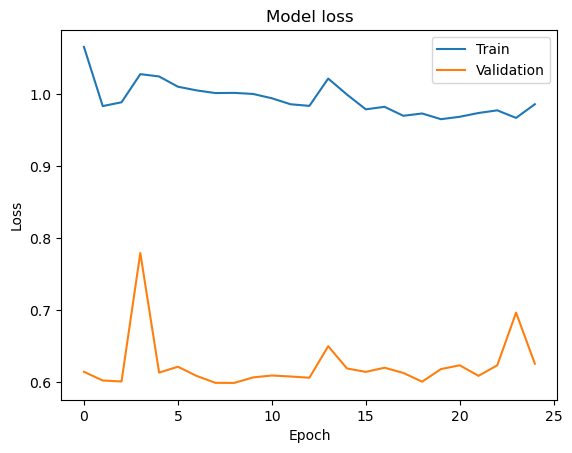

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# 

In [ ]:
predictions = BiLSTM_3layers.predict(X_test_encoded)
predictions = Yscaler.inverse_transform(predictions)
predictions = predictions.reshape(-1)
predictions.reshape(-1)
y_test_nonscale = Yscaler.inverse_transform(y_test).reshape(-1)


862/862 [==============================] - 47s 54ms/step


In [ ]:

print(X_test.shape)
print(y_test.shape)
# cut off the first of the tests
print(predictions.shape)
print(y_test_nonscale.shape)
y_test_nonscale = y_test_nonscale[lookback+forecast-1:]
print('new shape'+str(y_test_nonscale.shape))

(27866, 45)
(27866, 1)
(27579,)
(27866,)
new shape(27579,)


In [ ]:
pred_df = pd.DataFrame({'Actual': y_test_nonscale, 'Predicted': predictions})
pred_df.to_csv('Model_Outputs/predictions_BiLSTM_3layers_'+str(dt.datetime.now())+'.csv')

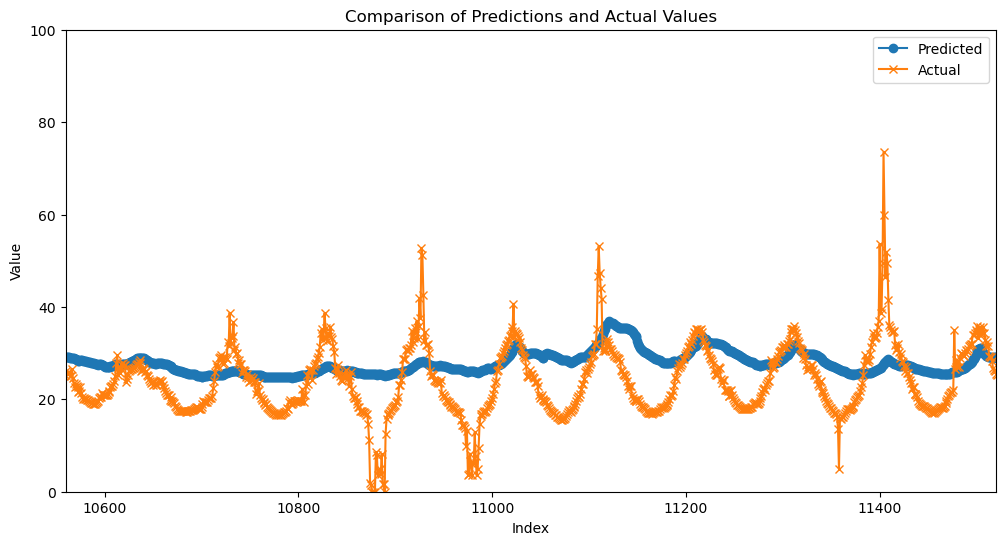

everything but show


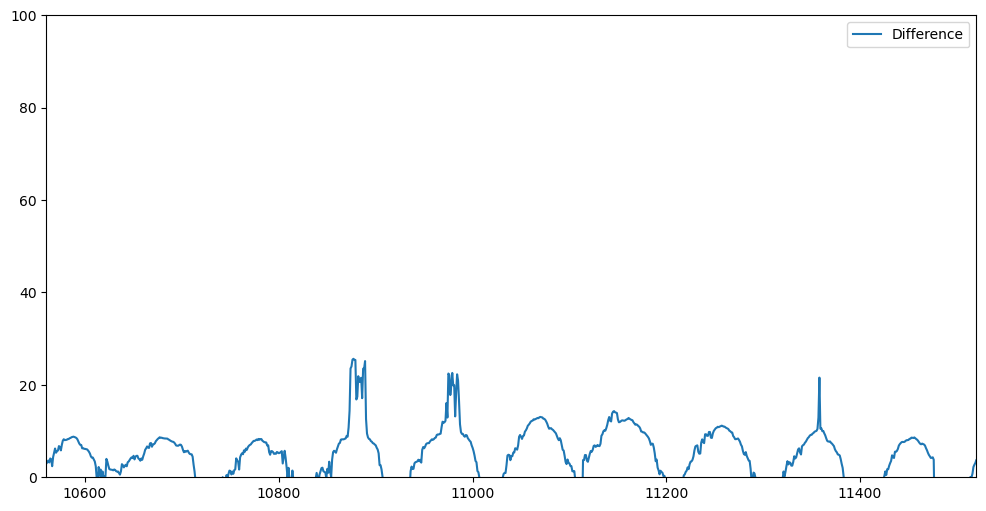

done


In [ ]:
# Define function to compare and plot model predictions from actual values
# Allow to zoom into a certain interval on the x axis

def plot_comparison(predictions, actual, startx=None, endx=None, starty=None, endy=None):
    """
    Plot the predicted vs actual values with an optional x-axis limit.

    Parameters:
        predictions (array-like): The predicted values.
        actual (array-like): The actual values.
        start (int, optional): Start index for x-axis limit.
        end (int, optional): End index for x-axis limit.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(predictions, label='Predicted', marker='o')  # Added markers for better visibility
    plt.plot(actual, label='Actual', marker='x')  # Added markers for better visibility
    plt.legend()
    
    # Set x-axis limits if specified
    if startx is not None or endx is not None:
        plt.xlim(startx, endx)
        
    # Set y-axis limits if specified
    if starty is not None or endy is not None:
        plt.ylim(starty, endy)    
    
    plt.title('Comparison of Predictions and Actual Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

    
    # Plot the differences between the actual value and the predicted value
    plt.figure(figsize=(12, 6))
    
    # Set x-axis limits if specified
    if startx is not None or endx is not None:
        plt.xlim(startx, endx)
        
    # Set y-axis limits if specified
    if starty is not None or endy is not None:
        plt.ylim(starty, endy)    
    
    plt.plot(predictions - actual, label='Difference')
    plt.legend()
    print('everything but show')
    plt.show()
    print('done')
    return
    
# Calculate the Mean Absolute Error
#mae_BiLSTM_3layers = mean_absolute_error(y_test, y_pred_BiLST_3layers)
#print(f'Mean Absolute Error: {mae_BiLSTM_3layers:.2f}')

# # Calculate the Mean Squared Error
# mse_BiLSTM_3layers = mean_squared_error(y_test, y_pred_BiLST_3layers)
# print(f'Mean Squared Error: {mse_BiLSTM_3layers:.2f}')
# shifted_predictions = np.roll(predictions, 288)
plot_comparison(predictions, y_test_nonscale, startx=96*110, endx=0+96*120, starty=0, endy=100)

Troubleshooting:

Check the variance in your y_train to ensure there is enough variance to predict.

Try using a different activation function like 'tanh' or 'sigmoid'.

Experiment with different architectures, reducing the complexity of the model.

Scale back the L2 regularization (i.e., lower the lambda value).

Try different batch sizes and number of epochs.

Plot the training and validation loss to see if the model is learning over time.


In [ ]:
X, y = encode_data(df=df)
# Use the function to trim the data
X_trimmed, y_trimmed = trim_data(X, y)
X_train, X_test, y_train, y_test, scaler_X, scaler_y = prep_LSTM_data(X=X_trimmed, y=y_trimmed)

# Make predictions
y_pred_3 = BiLSTM_3layers.predict(X_test)
# Flatten predictions and actual data
y_pred_3_flat = y_pred_3.reshape(-1)
y_test_flat = y_test.reshape(-1)

# In case these were not inverse transformed after prediction, do it here
y_pred_3_flat = scaler_y.inverse_transform(y_pred_3_flat.reshape(-1, 1)).flatten()
y_test_flat = scaler_y.inverse_transform(y_test_flat.reshape(-1, 1)).flatten()


# # Show accuracy
# mse = mean_squared_error(y_test_flat, y_pred_3_flat)
# rmse = np.sqrt(mse)
# print(f'Root Mean Squared Error: {rmse}')
# print(f'Accuracy: {100 - mse}%')

# Now you can call the plot_comparison function with properly formatted data
#plot_comparison(y_pred_3_flat, y_test_flat, startx=1700, endx=2000, starty=-10, endy=200)
X_train.shape

NameError: name 'encode_data' is not defined

In [ ]:
print(f"Shape of y_test: {y_test_flattened.shape}")
print(f"Shape of y_pred_3: {y_pred_3.shape}")


NameError: name 'y_test_flattened' is not defined

In [ ]:
# Save model_3
BiLSTM_3layers.save('model_3.h5')

# Load model_3
from keras.models import load_model
BiLSTM_3layers = load_model('model_3.h5')


/Users/lesarmstrong/miniconda3/envs/1.c51-env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Seq2Seq

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout

In [ ]:
# def create_sequences(X, y, input_length, prediction_length):
#     X_seq, y_seq = [], []
#     for i in range(len(X) - input_length - prediction_length + 1):
#         X_seq.append(X[i:(i + input_length)])
#         y_seq.append(y[(i + input_length):(i + input_length + prediction_length)])
#     return np.array(X_seq), np.array(y_seq)

# X, y = encode_data()

# input_seq_length = 48 * 4  # 48 hours with 15-minute intervals
# output_seq_length = 24 * 4  # 24 hours with 15-minute intervals

# X_sequences, y_sequences = create_sequences(X, y, input_seq_length, output_seq_length)
# y_sequences = y_sequences.reshape(y_sequences.shape[0], y_sequences.shape[1], 1)  # Reshaping for model compatibility

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)


### Model 3

input_seq_length: This should be the number of time steps you want your model to consider for each input sequence. It’s a hyperparameter you set based on your data or problem specifics.

output_seq_length: This is similar but for the output. For some sequence-to-sequence models, this might be the same as the input sequence length, or it might be different, such as when predicting future values or translating sentences to another language with different sentence lengths.

In [ ]:
# X, y = encode_data()

# input_seq_length = 48 * 4  # 48 hours with 15-minute intervals
# output_seq_length = 24 * 4  # 24 hours with 15-minute intervals

# X_sequences, y_sequences = create_sequences(X, y, input_seq_length, output_seq_length)
# y_sequences = y_sequences.reshape(y_sequences.shape[0], y_sequences.shape[1], 1)  # Reshaping for model compatibility

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# X_train.shape[2]

57

In [ ]:
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(28276, 192, 57) (7069, 192, 57) (28276, 96, 1) (7069, 96, 1)


In [ ]:
# df_trimmed = trim_data(df)
# X, y, months = encode_data(df=df_trimmed)
# # Use the function to trim the data
# #X_trimmed, y_trimmed = trim_data(X, y)
# X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, scaler_X, scaler_y = prep_LSTM_data(X=X, y=y, months=months)
# input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])  # (num_timesteps, num_features)

In [ ]:

# Define input sequence length and the number of features
input_seq_length = 48 * 4  # 48 hours x 4, 15 minutes intervals 
output_seq_length = 24 * 4  # 24 hours x 4, 15 minutes intervals
num_features = X_train_encoded.shape[2]  # Adjust this to match the second dimension of X_train after preprocessing

## SEQ2SEQ architecture

# Define the input shape for the encoder
encoder_inputs = Input(shape=(input_seq_length, num_features))

# Define the LSTM layers with dropout as you had previously set them up
encoder_lstm1 = LSTM(128, return_sequences=True, return_state=True, dropout=0.2)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)

encoder_lstm2 = LSTM(64, return_sequences=True, return_state=True, dropout=0.2)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)

encoder_lstm3 = LSTM(32, return_state=True, dropout=0.2)
encoder_outputs3, state_h3, state_c3 = encoder_lstm3(encoder_outputs2)
encoder_states = [state_h3, state_c3]

# Define the decoder input and LSTM layer with dropout using the last encoder states as initial state
decoder_inputs = Input(shape=(output_seq_length, 1))  # Assuming the output feature is 1
decoder_lstm = LSTM(32, return_sequences=True, return_state=False, dropout=0.2)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Add a dropout layer after the LSTM layers
decoder_dropout = Dropout(0.2)(decoder_outputs)

# Define the dense output layer
decoder_dense = Dense(1, activation='linear')
decoder_outputs = decoder_dense(decoder_dropout)

# Define the Seq2Seq model that will turn `encoder_inputs` & `decoder_inputs` into `decoder_outputs`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 192, 57)]            0         []                            
                                                                                                  
 lstm_73 (LSTM)              [(None, 192, 128),           95232     ['input_31[0][0]']            
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                                  
 lstm_74 (LSTM)              [(None, 192, 64),            49408     ['lstm_73[0][0]']             
                              (None, 64),                                                  

In [ ]:
# Create a Zero-Padded Initial Input for the Decoder
decoder_input_train = np.zeros((y_train.shape[0], y_train.shape[1], 1))  # 
decoder_input_test = np.zeros((y_test.shape[0], y_test.shape[1], 1))  # 

## TODO do we train on encoded sequences?
history = model.fit(
    [X_train, decoder_input_train],  # Provide initial state for the decoder
    y_train,                         # Actual target outputs for training
    epochs=10,
    batch_size=64,
    validation_data=([X_test, decoder_input_test], y_test)  # Similar setup for validation
)


Epoch 1/10
442/442 [==============================] - 179s 381ms/step - loss: 5777.6396 - mae: 14.0405 - val_loss: 6221.1357 - val_mae: 9.7268
Epoch 2/10
442/442 [==============================] - 177s 400ms/step - loss: 5609.6436 - mae: 9.9086 - val_loss: 6186.1729 - val_mae: 10.2030
Epoch 3/10
442/442 [==============================] - 185s 418ms/step - loss: 5598.8970 - mae: 10.5413 - val_loss: 6184.3032 - val_mae: 10.7283
Epoch 4/10
442/442 [==============================] - 173s 391ms/step - loss: 5598.2153 - mae: 10.7657 - val_loss: 6184.2856 - val_mae: 10.7505
Epoch 5/10
442/442 [==============================] - 166s 376ms/step - loss: 5598.4697 - mae: 10.7884 - val_loss: 6184.3560 - val_mae: 10.6792
Epoch 6/10
442/442 [==============================] - 166s 375ms/step - loss: 5598.3394 - mae: 10.7045 - val_loss: 6184.2852 - val_mae: 10.9283
Epoch 7/10
442/442 [==============================] - 218s 495ms/step - loss: 5598.3228 - mae: 10.8359 - val_loss: 6184.3428 - val_mae: 10

In [ ]:
# Create the initial input for the decoder for prediction
decoder_input_test = np.zeros((y_test.shape[0], y_test.shape[1], 1))  # Assuming the same shape as during training

# Make predictions using the model
predictions = model.predict([X_test, decoder_input_test])

221/221 [==============================] - 21s 82ms/step


In [ ]:
# Flatten the predictions and actual values if they are in three dimensions
predictions = predictions.reshape(-1)
actual = y_test.reshape(-1)


Mean Squared Error: 6192.209068663043
Mean Absolute Error: 9.436576292437172


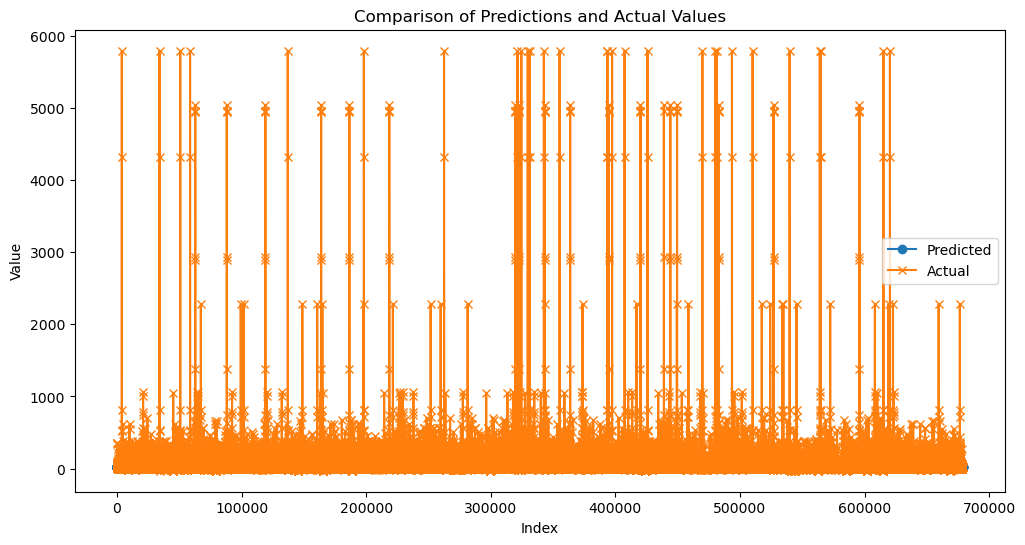

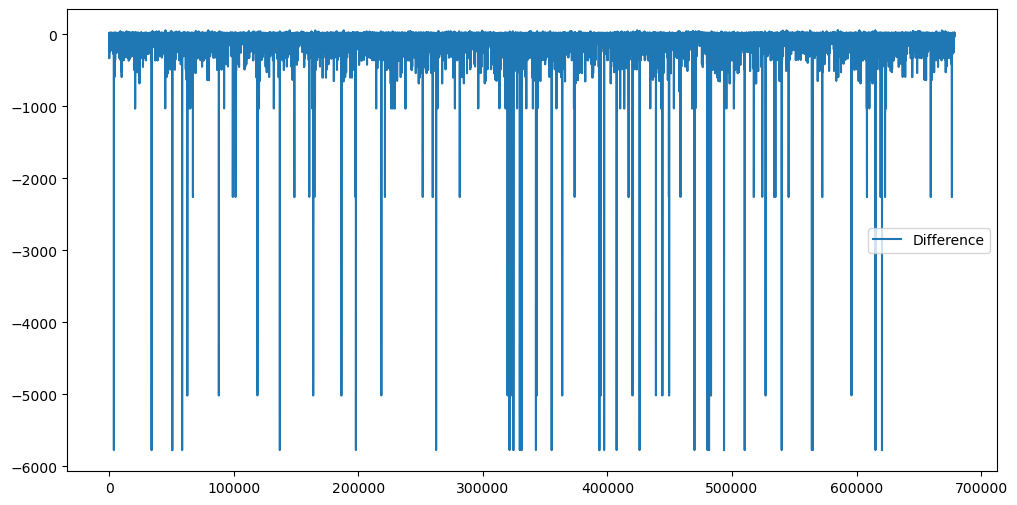

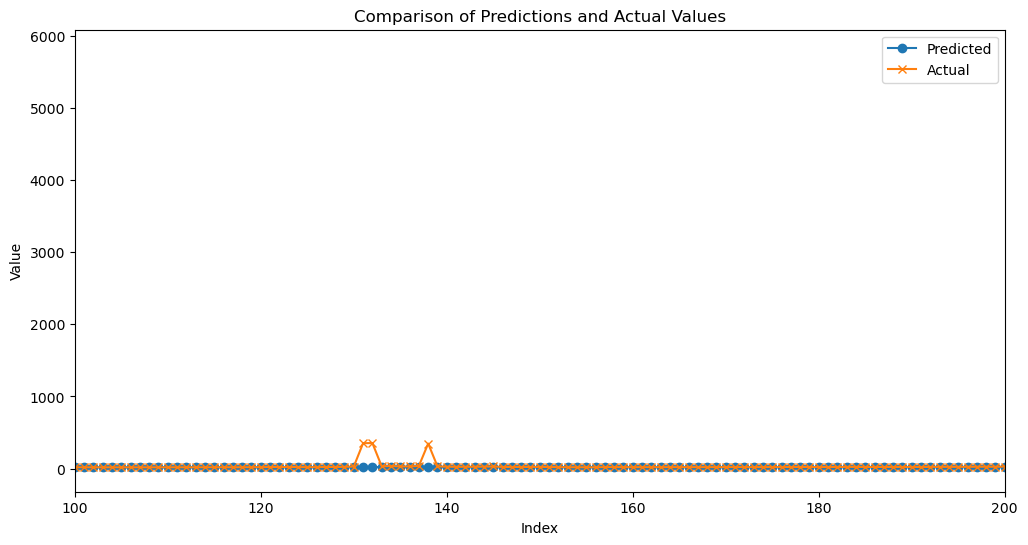

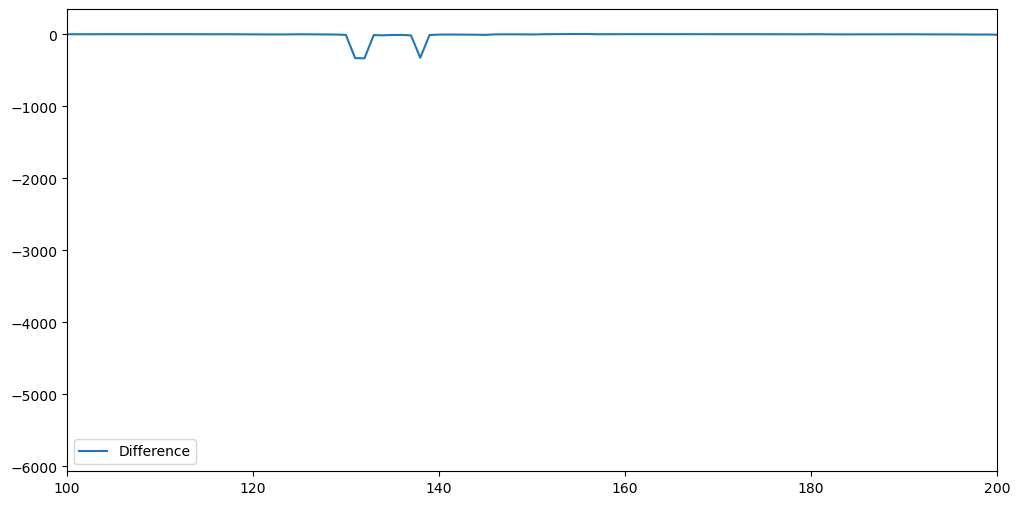

In [ ]:
mse = mean_squared_error(actual, predictions)
mae = mean_absolute_error(actual, predictions)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Plot the overall comparison
plot_comparison(predictions, actual)

# Plot a specific interval for detailed analysis
start_index = 100  # example start index
end_index = 200    # example end index
plot_comparison(predictions, actual, startx=start_index, endx=end_index)


## Bands

In [ ]:
    y_test.shape

(7127, 1)